In [1]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.preprocessing import image
from tensorflow.keras.layers import Input, Lambda ,Dense ,Flatten ,Dropout
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
import keras
from natsort import natsorted

## Get Data

In [2]:
def get_images(images_path):
    # speichert Bilder als numpy array

    array_images = []
    train_or_test_folder = os.listdir(images_path)

    for folder in natsorted(train_or_test_folder):
        single_folder = os.path.join(images_path, folder)

        for file in os.listdir(single_folder):
            filepath = os.path.join(single_folder, file)

            if filepath.lower().endswith(('.jpeg', '.jpg')):
                image = cv2.resize(cv2.imread(filepath), (64, 64))  # resize Größe bestimmt durch vortainiertes Netz
                array_images.append(image)

    images = np.array(array_images)
    
    return images

In [3]:
def get_label(images_path):
    # speichert Lables als numpy array

    array_label = []
    for folder in natsorted(os.listdir(images_path)):
        label = int(folder)

        for file in os.listdir(os.path.join(images_path, folder)):
            array_label.append(label)
    labels = np.array(array_label)
        
    return labels

In [4]:
images = get_images("../../02_data_crop/train") # train images
labels = get_label("../../02_data_crop/train")  # train labels

In [37]:
import numpy as np
print(images[0].shape)
print(labels[0])

(64, 64, 3)
0


In [6]:
uniq_labels = natsorted(os.listdir("../../02_data_crop/train"))
print("Anzahl eindeutiger Klassen: {}".format(len(uniq_labels)))

Anzahl eindeutiger Klassen: 26


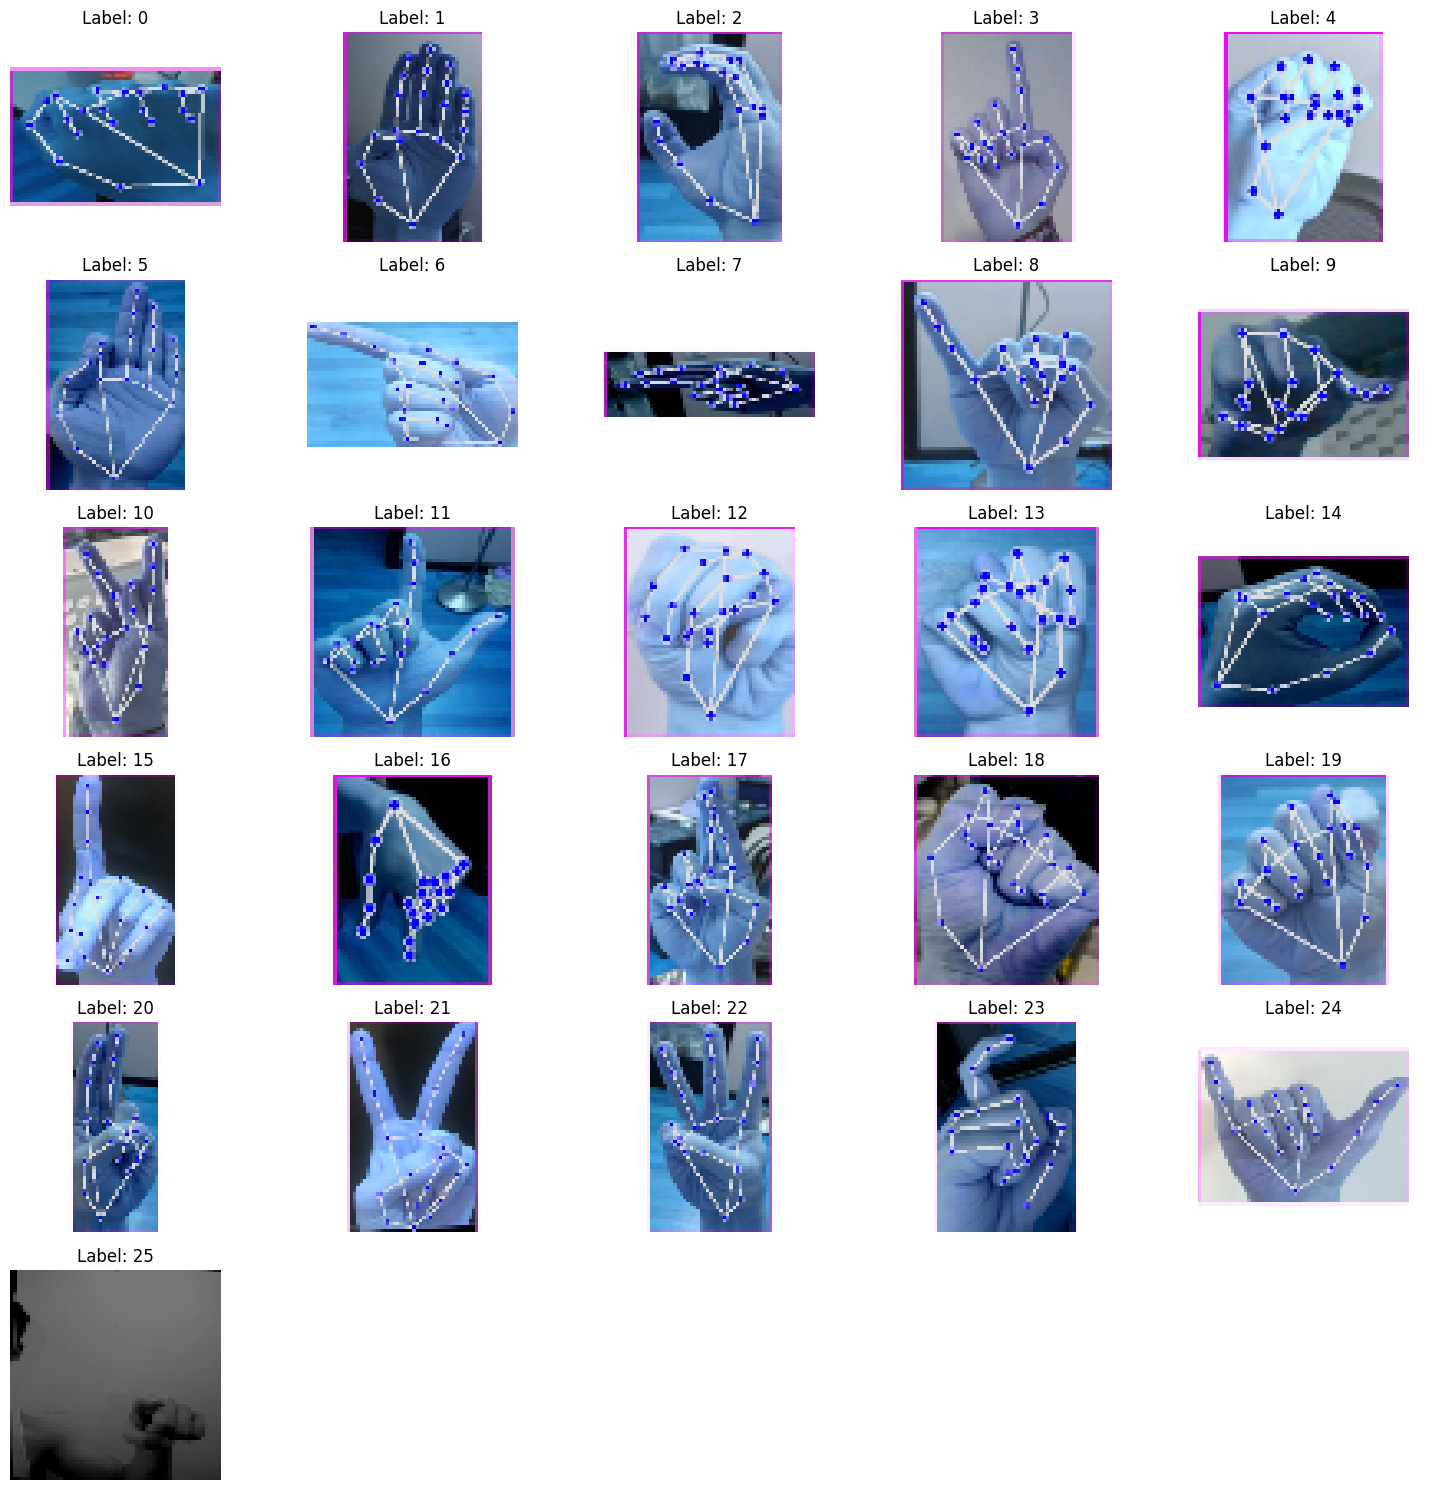

In [24]:
unique_labels = np.unique(labels)
num_cols = 5  # Anzahl der Spalten im Subplot
num_rows = (len(unique_labels) // num_cols) + 1  # Berechne die Anzahl der Zeilen im Subplot

fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))

for i, label in enumerate(unique_labels):
    # Finde den Index des ersten Bildes mit dem aktuellen Label
    index = np.where(labels == label)[0][0]

    # Berechne die Position im Subplot
    row = i // num_cols
    col = i % num_cols

    # Zeige das Bild im Subplot an
    axs[row, col].imshow(images[index])
    axs[row, col].set_title(f"Label: {label}")
    axs[row, col].axis('off')

# Verstecke leere Subplots
for i in range(len(unique_labels), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()

## Preprocessing

In [7]:
from sklearn.model_selection import train_test_split
from tabulate import tabulate

# Trainingsbilder, Testbilder, Trainingslabels, Testlabels
X_train, X_eval, y_train, y_eval = train_test_split(images, labels, test_size = 0.2, shuffle=True, stratify = labels)
# von jeder Klasse Daten

n = len(uniq_labels)   # Anzahl eindeutiger Klassen
train_n = len(X_train) # Anzahl Trainingsdaten
eval_n = len(X_eval)

tab = [['Klassen:',n],
       ['Trainingsbilder', train_n],['Evaluierungsbilder', eval_n]]

print(tabulate(tab, headers=["Anzahl", "Wert"]))

Anzahl                Wert
------------------  ------
Klassen:                26
Trainingsbilder       8294
Evaluierungsbilder    2074


In [40]:
print(X_train[0].shape)

(64, 64, 3)


In [8]:
# one hot encoding der Labels
# Binarisierung, entsprechende Klasse mit 1 gekennzeichnet
y_train = keras.utils.to_categorical(y_train)
y_eval = keras.utils.to_categorical(y_eval)

In [9]:
print("One hot encoded: {}".format(y_train[0]))
print("Anzahl Klassen: {}".format(len(y_train[0])))
# Dummy Klasse, wenn kein Wert passt

One hot encoded: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0.]
Anzahl Klassen: 26


In [10]:
# Normalisierung der Bilder, damit Werte nur noch zwischen 0 und 1
X_train = X_train.astype('float32')/255.0
X_eval = X_eval.astype('float32')/255.0

print(X_train[0].shape)

(64, 64, 3)


In [17]:
label_to_letter = {0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6:'g', 7:'h', 8:'i', 9:'j', 10:'k', 11:'l', 12:'m', 13:'n', 14:'o', 15:'p', 16:'q', 17:'r', 18:'s', 
                   19:'t', 20:'u', 21:'v', 22:'w', 23:'x', 24:'y', 25: 'z'}


Label des zufälligen Bildes:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
Ursprünglicher Labelwert des ersten Bildes:
14
Label als Buchstabe
o


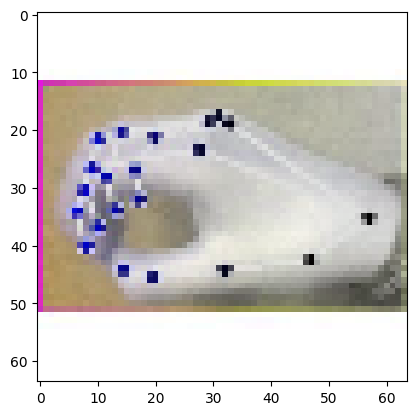

In [18]:
import random

# Zufälligen Index wählen
index = random.randint(0, len(X_train) - 1)

print("Label des zufälligen Bildes:")
print(y_train[index])

# Konvertieren des one hot encoded Labels zurück in den ursprünglichen Labelwert
label_value = np.argmax(y_train[index])
print("Ursprünglicher Labelwert des ersten Bildes:")
print(label_value)

letter = label_to_letter[label_value]
print("Label als Buchstabe")
print(letter)

# Anzeigen des ersten Bildes
plt.imshow(X_train[index])
plt.show()

## Model 1: VGG16

In [19]:
#Initialising vgg16 
classifier_vgg16 = VGG16(input_shape= (64,64,3),include_top=False,weights='imagenet')

In [20]:
#don't train existing weights for vgg16
for layer in classifier_vgg16.layers:
    layer.trainable = False

In [21]:
classifier1 = classifier_vgg16.output#head mode
classifier1= Flatten()(classifier1)#adding layer of flatten
classifier1 = Dense(units=256, activation='relu')(classifier1)
classifier1 = Dropout(0.6)(classifier1)
classifier1 = Dense(units=26, activation='softmax')(classifier1)  # 27 units for 27 classes

model_vgg16 = Model(inputs = classifier_vgg16.input , outputs = classifier1)
model_vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
model_vgg16.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 26)             │         6,682 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,245,914 (58.16 MB)

 Trainable params: 531,226 (2.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [23]:
#fit the model
history_vgg16 = model_vgg16.fit(X_train, y_train, epochs =5, batch_size = 64,validation_data=(X_eval,y_eval))

Epoch 1/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 97s 709ms/step - accuracy: 0.1836 - loss: 2.8458 - val_accuracy: 0.5892 - val_loss: 1.6201
Epoch 2/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 93s 715ms/step - accuracy: 0.4831 - loss: 1.7043 - val_accuracy: 0.7170 - val_loss: 1.1822
Epoch 3/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 93s 713ms/step - accuracy: 0.5903 - loss: 1.3366 - val_accuracy: 0.7551 - val_loss: 0.9478
Epoch 4/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 102s 782ms/step - accuracy: 0.6699 - loss: 1.0935 - val_accuracy: 0.8014 - val_loss: 0.7798
Epoch 5/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 92s 707ms/step - accuracy: 0.7159 - loss: 0.9406 - val_accuracy: 0.8308 - val_loss: 0.7000


In [24]:
# Saving the model of vgg16
model_vgg16.save('./model_vgg16.h5')

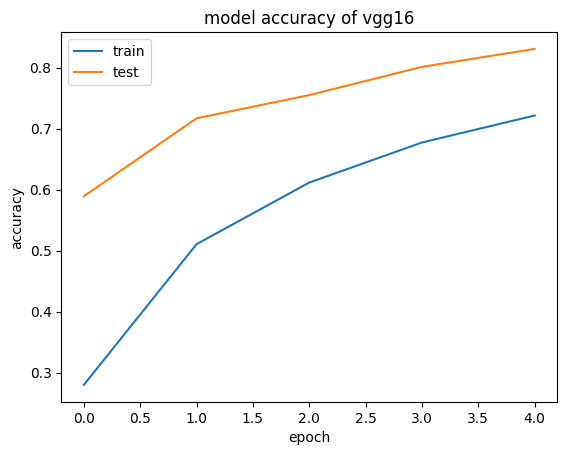

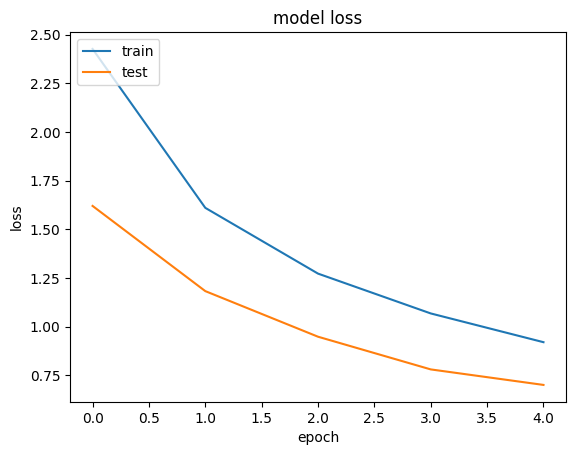

In [25]:
# summarize history for accuracy
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
plt.title('model accuracy of vgg16')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss

plt.plot(history_vgg16.history['loss'])
plt.plot(history_vgg16.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

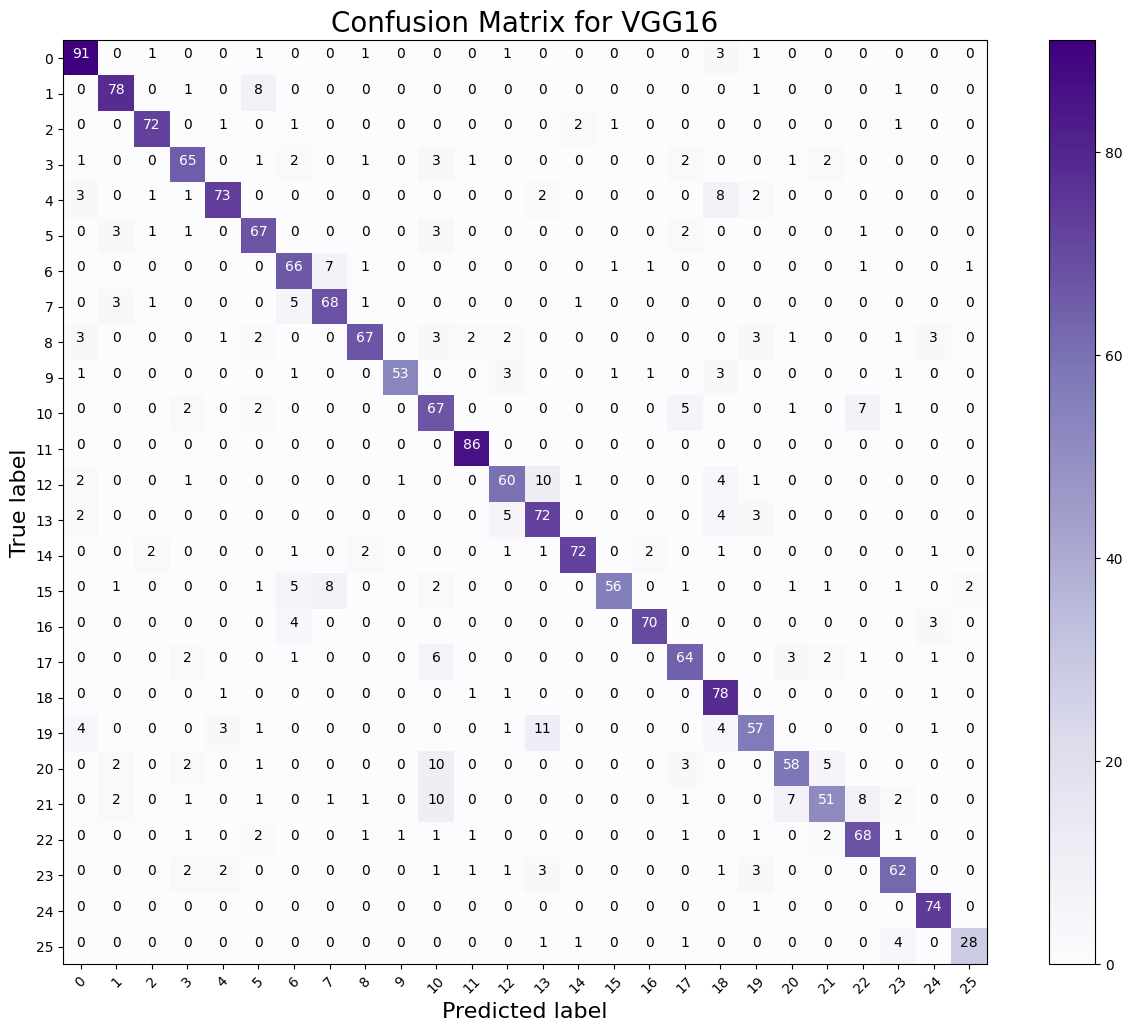

In [26]:
#Helper function to plot confusion matrix
def plot_confusion_matrix(y, y_pred):
    y = np.argmax(y, axis = 1)
    y_pred = np.argmax(y_pred, axis = 1)
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize = (16, 12))
    ax = plt.subplot()
    plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Purples)
    plt.colorbar()
    plt.title("Confusion Matrix for VGG16")
    tick_marks = np.arange(len(uniq_labels))
    plt.xticks(tick_marks, uniq_labels, rotation=45)
    plt.yticks(tick_marks, uniq_labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    ax.title.set_fontsize(20)
    ax.xaxis.label.set_fontsize(16)
    ax.yaxis.label.set_fontsize(16)
    limit = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment = "center",color = "white" if cm[i, j] > limit else "black")
    plt.show()

from sklearn.metrics import confusion_matrix
import itertools

y_eval_pred = model_vgg16.predict(X_eval, batch_size = 512,verbose = 0)
plot_confusion_matrix(y_eval, y_eval_pred)

## Test

In [27]:
X_test = get_images("../../02_data_crop/test")  # Evaluierungs Bilder
y_test = get_label("../../02_data_crop/test")   # Evaluierungs Labels

y_test = keras.utils.to_categorical(y_test)
X_test = X_test.astype('float32')/255.0

In [28]:
score = model_vgg16.evaluate(x = X_test, y = y_test, verbose = 0)
print('Accuracy for test images:', round(score[1]*100, 3), '%')

Accuracy for test images: 69.682 %


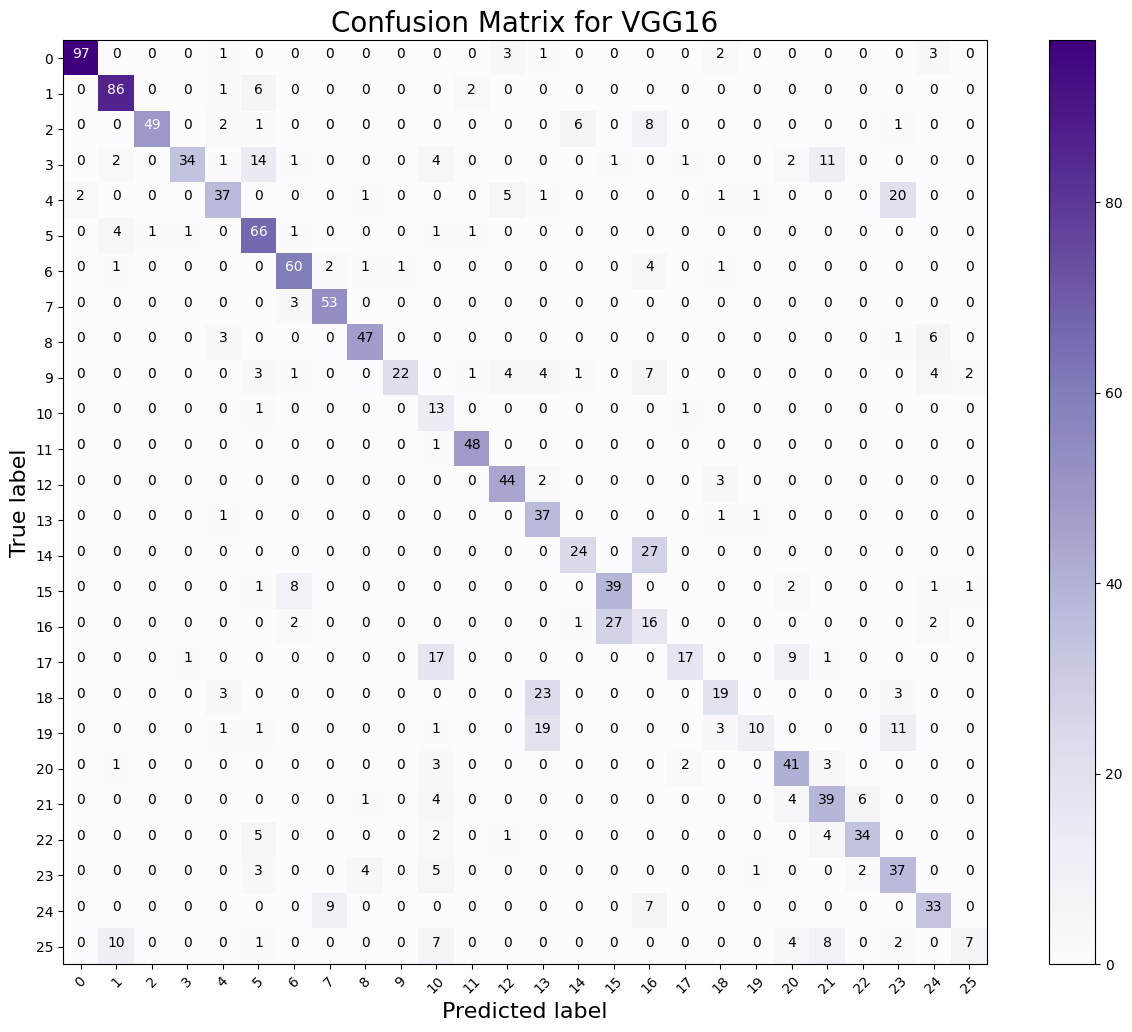

In [29]:
#Helper function to plot confusion matrix
def plot_confusion_matrix(y, y_pred):
    y = np.argmax(y, axis = 1)
    y_pred = np.argmax(y_pred, axis = 1)
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize = (16, 12))
    ax = plt.subplot()
    plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Purples)
    plt.colorbar()
    plt.title("Confusion Matrix for VGG16")
    tick_marks = np.arange(len(uniq_labels))
    plt.xticks(tick_marks, uniq_labels, rotation=45)
    plt.yticks(tick_marks, uniq_labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    ax.title.set_fontsize(20)
    ax.xaxis.label.set_fontsize(16)
    ax.yaxis.label.set_fontsize(16)
    limit = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment = "center",color = "white" if cm[i, j] > limit else "black")
    plt.show()

from sklearn.metrics import confusion_matrix
import itertools

y_test_pred = model_vgg16.predict(X_test, batch_size = 64, verbose = 0)
plot_confusion_matrix(y_test, y_test_pred)

ValueError: as_list() is not defined on an unknown TensorShape.

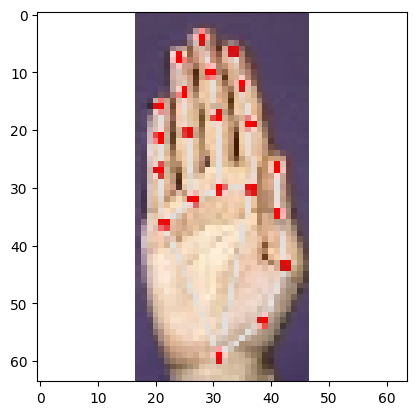

In [32]:
# for only one prediction
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('../test_images/00001.jpg',target_size=(64,64))
plt.imshow(test_image)
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
result = model_vgg16.predict(test_image)
print(result[0])


if result[0][0] == 1:
    prediction = 'A'
elif result[0][1] == 1:
    prediction = 'B'
elif result[0][2] == 1:
    prediction = 'C'
elif result[0][3] == 1:
    prediction = 'D'
elif result[0][4] == 1:
    prediction = 'E'
elif result[0][5] == 1:
    prediction = 'F'
elif result[0][6] == 1:
    prediction = 'G'
elif result[0][7] == 1:
    prediction = 'H'
elif result[0][8] == 1:
    prediction = 'I'
elif result[0][9] == 1:
    prediction = 'J'
elif result[0][10] == 1:
    prediction = 'K'
elif result[0][11] == 1:
    prediction = 'L'
elif result[0][12] == 1:
    prediction = 'M'
elif result[0][13] == 1:
    prediction = 'N'
elif result[0][14] == 1:
    prediction = 'O'
elif result[0][15] == 1:
    prediction = 'P'
elif result[0][16] == 1:
    prediction = 'Q'
elif result[0][17] == 1:
    prediction = 'R'
elif result[0][18] == 1:
    prediction = 'S'
elif result[0][19] == 1:
    prediction = 'T'
elif result[0][20] == 1:
    prediction = 'U'
elif result[0][21] == 1:
    prediction = 'V'
elif result[0][22] == 1:
    prediction = 'W'
elif result[0][23] == 1:
    prediction = 'X'
elif result[0][24] == 1:
    prediction = 'Y'
elif result[0][25] == 1:
    prediction = 'Z'


else:
    prediction = '  '
    
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Vorhergesagte Klasse:  E


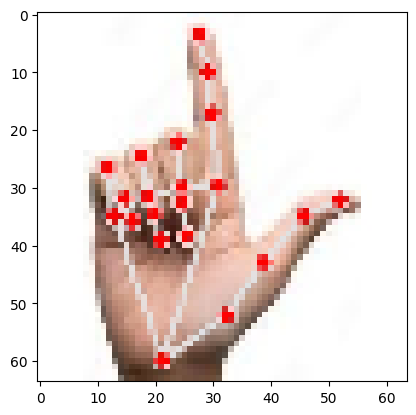

In [31]:
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('../test_images/00002.jpg',target_size=(64,64))
plt.imshow(test_image)
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
result = model_vgg16.predict(test_image)

# Finde den Index des höchsten Werts in result
predicted_class_index = np.argmax(result)

# Lade die Klassenbezeichnungen
class_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'] # Füge hier deine Klassenbezeichnungen hinzu

# Zeige die Vorhersage an
print("Vorhergesagte Klasse: ", class_labels[predicted_class_index])